In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


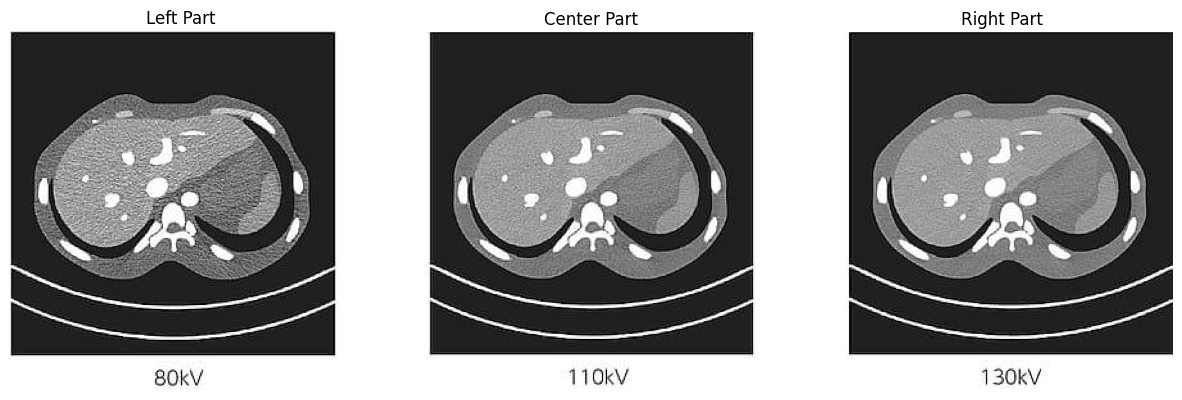

In [2]:
import cv2
import matplotlib.pyplot as plt

# Читаем изображение
image = cv2.imread('/Users/kpolekhina/Documents/vscode/cv.jpg', cv2.IMREAD_GRAYSCALE) # Преобразование в градации серого

# Определяем размеры
height, width = image.shape

# Разделяем по ширине на 3 части
part1 = image[:, 0:width // 3]          # Левая часть
part2 = image[:, width // 3:2 * width // 3]  # Центральная часть
part3 = image[:, 2 * width // 3:width]  # Правая часть

# Отображение результатов
plt.figure(figsize=(15, 5))

# Отображение левой части
plt.subplot(1, 3, 1)
plt.imshow(part1, cmap='gray')
plt.title('Left Part')
plt.axis('off')

# Отображение центральной части
plt.subplot(1, 3, 2)
plt.imshow(part2, cmap='gray')
plt.title('Center Part')
plt.axis('off')

# Отображение правой части
plt.subplot(1, 3, 3)
plt.imshow(part3, cmap='gray')
plt.title('Right Part')
plt.axis('off')

# Показываем все изображения
plt.show()


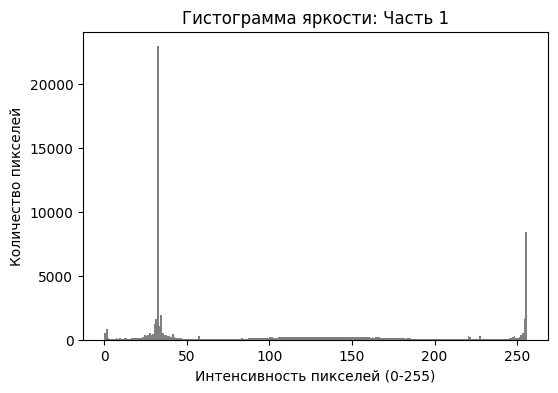

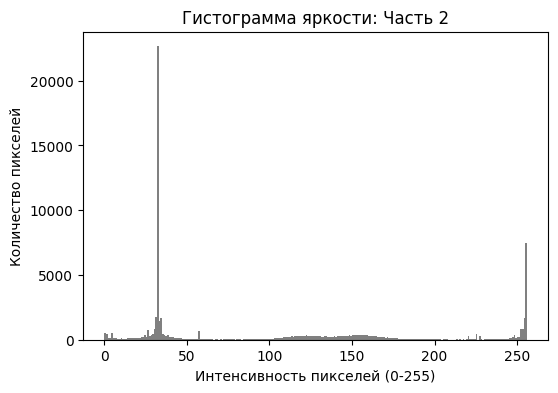

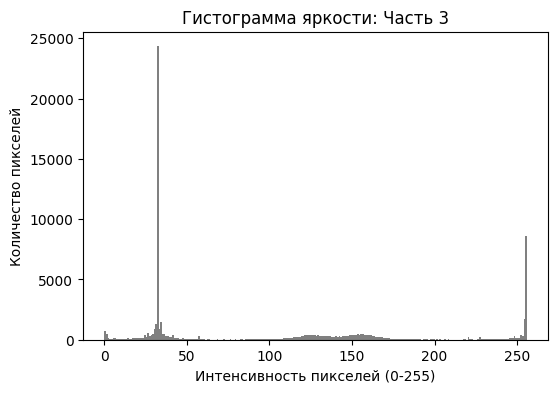

In [3]:
parts = (part1, part2, part3)
for i, part in enumerate(parts):
    plt.figure(figsize=(6, 4))
    plt.title(f"Гистограмма яркости: Часть {i+1}")
    plt.xlabel("Интенсивность пикселей (0-255)")
    plt.ylabel("Количество пикселей")
    
    # Строим гистограмму (ravel разворачивает массив в 1D)
    plt.hist(part.ravel(), bins=256, range=[0, 256], color='gray')
    plt.show()

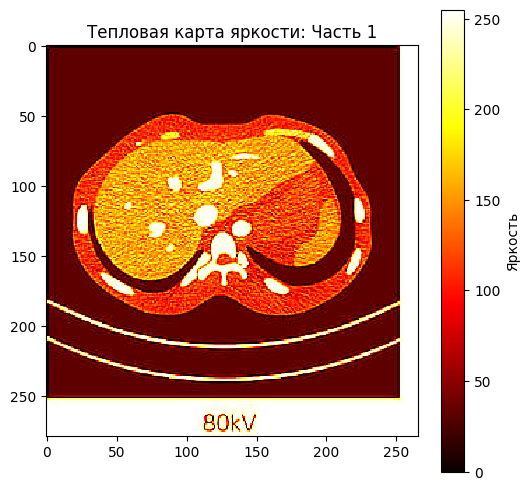

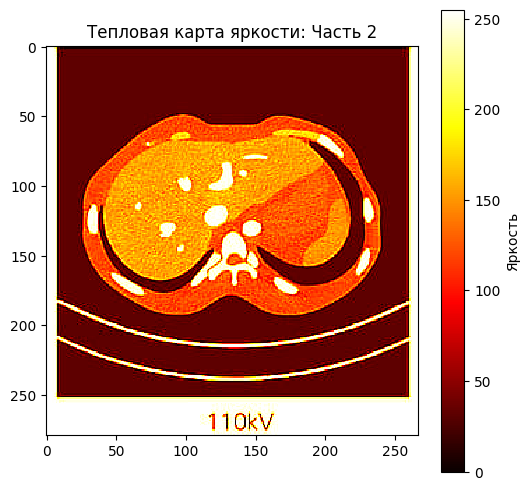

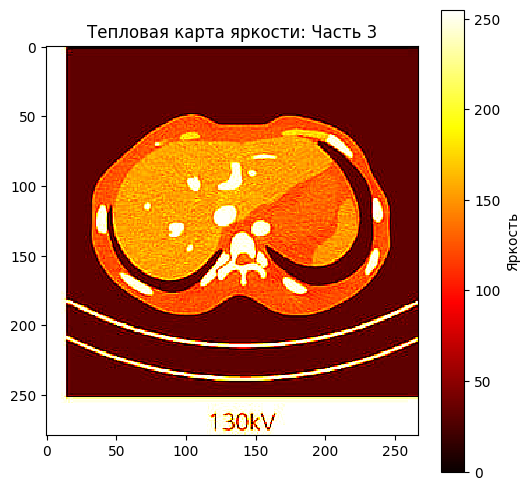

In [4]:
# Тепловая карта для каждой части
for i, part in enumerate(parts):
    plt.figure(figsize=(6, 6))
    plt.title(f"Тепловая карта яркости: Часть {i+1}")
    plt.imshow(part, cmap='hot', interpolation='nearest')  # colormap 'hot' делает тепловую карту
    plt.colorbar(label="Яркость")  # Добавляем шкалу
    plt.show()

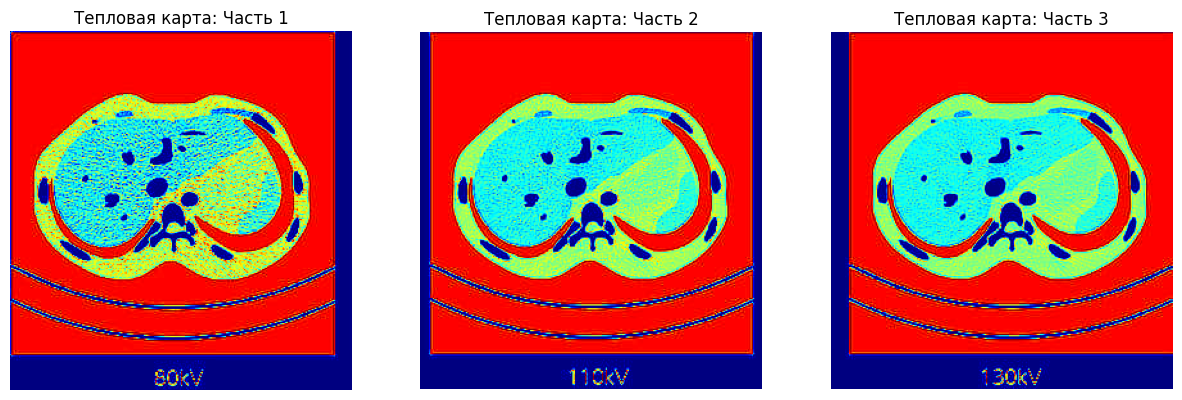

In [5]:
# Применяем цветовую карту (например, JET)
plt.figure(figsize=(15, 5))

for i, part in enumerate(parts):
    # Применение цветовой карты JET
    heatmap = cv2.applyColorMap(part, cv2.COLORMAP_JET)

    # Отображение тепловой карты
    plt.subplot(1, 3, i+1)
    plt.imshow(heatmap)
    plt.title(f'Тепловая карта: Часть {i+1}')
    plt.axis('off')

    # Сохранение тепловой карты
    cv2.imwrite(f"heatmap_part_{i+1}.png", heatmap)

# Показываем все изображения
plt.show()

In [6]:
# image = cv2.imread('/Users/kpolekhina/Documents/vscode/cv.jpg', cv2.IMREAD_GRAYSCALE) # Преобразование в градации серого

# # Определяем размеры
# height, width = image.shape

# # Разделяем по ширине на 3 части
# part1 = image[:, 0:width // 3]          # Левая часть
# part2 = image[:, width // 3:2 * width // 3]  # Центральная часть
# part3 = image[:, 2 * width // 3:width]  # Правая часть

# parts = (part1, part2, part3)

МОМЕНТЫ (i=1,4)

In [7]:
def moments_calc(img, powers=[1, 2, 3, 4]):
    strt_moments = []
    cntr_moments = [0 for _ in range(len(powers))]
    height, width = img.shape
    multiplicity = height * width

    for power in powers:
        moment = np.sum(np.power(img, power)) / multiplicity
        strt_moments.append(moment)

    mean_value = strt_moments[0]  # Среднее значение изображения
    cntr_moments[1] = strt_moments[1] - mean_value ** 2  # Второй центральный момент (дисперсия)
    cntr_moments[2] = strt_moments[2] - 3 * mean_value * strt_moments[1] + 2 * mean_value ** 2  # Третий центральный момент
    cntr_moments[3] = strt_moments[3] - 4 * mean_value * strt_moments[2] + 6 * mean_value ** 2 * strt_moments[1] - 3 * mean_value ** 4  # Четвёртый центральный момент

    strt_moments = [round(float(x), 3) for x in strt_moments]
    cntr_moments = [round(float(x), 3) for x in cntr_moments]

    return strt_moments, cntr_moments


ЭНТРОПИЯ (СОБСТВЕННАЯ СРЕДНЯЯ ИНФОРМАЦИЯ)

In [8]:
def entropy_calc(img):
    # Гистограмма яркости (256 уровней серого для 8-битного изображения)
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    
    # Нормализация гистограммы (вероятности)
    probabilities = hist / np.sum(hist)
    
    # Удаление нулевых вероятностей (во избежание log(0))
    probabilities = probabilities[probabilities > 0]
    
    # Расчёт энтропии по формуле
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return round(float(entropy), 3)


ЭНТРОПИЯ (ЧЕРЕЗ ГИСТОГРАММУ)

In [9]:
def calculate_entropy_with_histogram(img):
    # Гистограмма яркости (256 уровней для 8-битного изображения)
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    
    # Сумма всех значений гистограммы (общее количество пикселей)
    total_pixels = np.sum(hist)
    
    # Фильтрация нулевых значений для G_h, чтобы избежать log(0)
    non_zero_hist = hist[hist > 0]
    
    # Первая часть: log2(sum)
    term1 = np.log2(total_pixels)
    
    # Вторая часть: (1 / sum) * Σ(G_h * log2(G_h))
    term2 = np.sum(non_zero_hist * np.log2(non_zero_hist)) / total_pixels
    
    # Энтропия
    entropy = term1 - term2
    
    return round(float(entropy), 3)

ИЗБЫТОЧНОСТЬ

In [10]:
def calculate_redundancy(img):
    # Гистограмма яркости
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    
    # Общее количество пикселей
    total_pixels = np.sum(hist)
    
    # Вычисление энтропии I
    non_zero_hist = hist[hist > 0]
    term1 = np.log2(total_pixels)
    term2 = np.sum(non_zero_hist * np.log2(non_zero_hist)) / total_pixels
    I = term1 - term2
    
    # Вычисление максимальной энтропии I_0
    h_max = 255  # Максимальный уровень (для 8-битных изображений)
    h_min = 0    # Минимальный уровень
    I_0 = np.log2(h_max - h_min + 1)
    
    # Вычисление избыточности D
    D = 1 - (I / I_0)
    
    return D


In [11]:
for i, part in enumerate(parts):
    part_float = part.astype(np.float32)

    start_moms, center_moms = moments_calc(part_float)
    entropy1 = entropy_calc(part_float)
    entropy2 = calculate_entropy_with_histogram(part_float)
    redundancy = calculate_redundancy(part_float)
    print(f'Для части {i+1}: ')
    print(f'Начальные моменты: {start_moms}')
    print(f'Центральные моменты: {center_moms}')
    print(f'Энтропия (как средняя собственная ифнормация): {entropy1:.4f}')
    print(f'Энтропия (через гистограмму): {entropy2:.4f}')
    print(f'Избыточность: {redundancy:.4f}')


Для части 1: 
Начальные моменты: [101.493, 17842.936, 3821336.75, 880458944.0]
Центральные моменты: [0.0, 7542.086, -1590866.0, 113563488.0]
Энтропия (как средняя собственная ифнормация): 5.5820
Энтропия (через гистограмму): 5.5820
Избыточность: 0.3023
Для части 2: 
Начальные моменты: [103.384, 18136.863, 3844058.25, 877560448.0]
Центральные моменты: [0.0, 7448.704, -1759725.375, 108298784.0]
Энтропия (как средняя собственная ифнормация): 5.5510
Энтропия (через гистограмму): 5.5510
Избыточность: 0.3061
Для части 3: 
Начальные моменты: [103.15, 18072.588, 3828788.5, 874471168.0]
Центральные моменты: [0.0, 7432.765, -1742467.875, 108837632.0]
Энтропия (как средняя собственная ифнормация): 5.3250
Энтропия (через гистограмму): 5.3250
Избыточность: 0.3343


ПРИМЕНИМ ФИЛЬТРЫ К ИЗОБРАЖЕНИЯМ

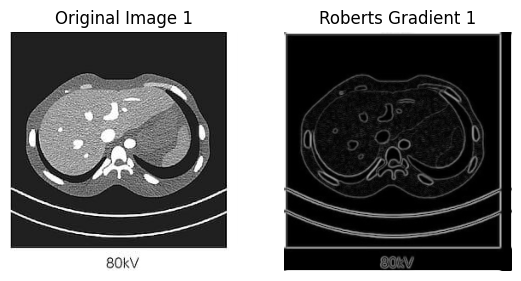

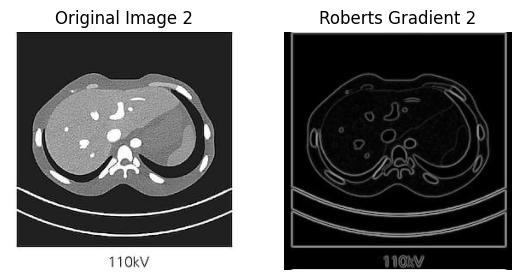

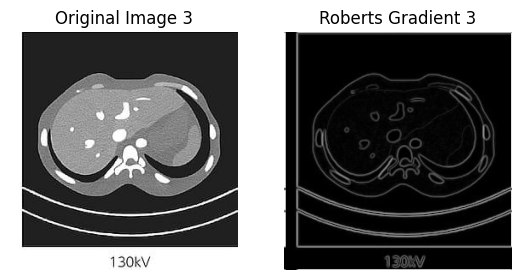

In [12]:
for i, part in enumerate(parts):
    # 1. Сглаживание с помощью Гауссового фильтра (если нужно)
    blurred_part = cv2.GaussianBlur(part, (3, 3), 1)

    # 2. Сшивание краёв (T-схема: циклические границы)
    extended_image = cv2.copyMakeBorder(blurred_part, 1, 1, 1, 1, cv2.BORDER_WRAP)  # Создание расширенной области с тороидальными границами

    # 3. Применяем оператор Робертса для выделения контуров
    kernel_x = np.array([[1, 0], [0, -1]])  # Ядро для градиента по X
    kernel_y = np.array([[0, 1], [-1, 0]])  # Ядро для градиента по Y

    grad_x = cv2.filter2D(extended_image, cv2.CV_64F, kernel_x)  # Градиент по X
    grad_y = cv2.filter2D(extended_image, cv2.CV_64F, kernel_y)  # Градиент по Y

    # Градиентная амплитуда (модуль Робертса)
    roberts_grad = cv2.magnitude(grad_x, grad_y)
    roberts_grad = np.uint8(np.clip(roberts_grad, 0, 255))  # Приводим к диапазону [0, 255]

    # 4. Отображение результатов
    plt.figure(figsize=(10, 5))

    # Отображение оригинального изображения
    plt.subplot(1, 3, 1)
    plt.imshow(part, cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Отображение результата Робертса
    plt.subplot(1, 3, 2)
    plt.imshow(roberts_grad, cmap='gray')
    plt.title(f'Roberts Gradient {i+1}')
    plt.axis('off')

    # Показываем все изображения
    plt.show()


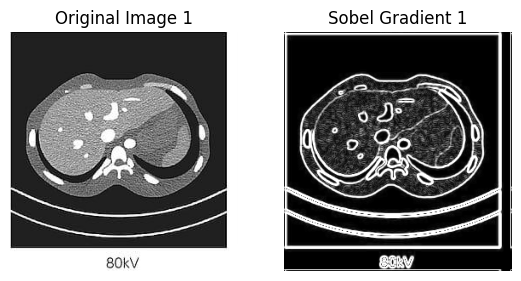

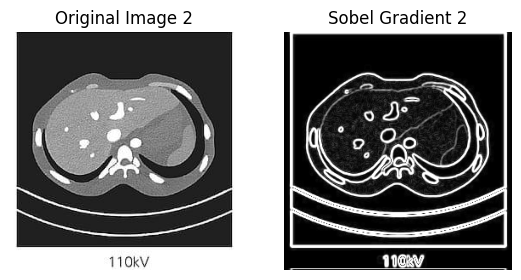

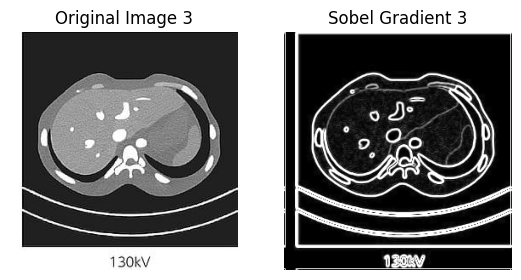

In [13]:
new_parts = []
for i, part in enumerate(parts):
    blurred_part = cv2.GaussianBlur(part, (3, 3), 1)

    # 1. Сшивание краёв (T-схема: циклические границы)
    extended_image = cv2.copyMakeBorder(blurred_part, 1, 1, 1, 1, cv2.BORDER_WRAP)  # Создание расширенной области с тороидальными границами

    # 2. Применяем оператор Собеля для выделения контуров (градиенты по X и Y)
    grad_x = cv2.Sobel(extended_image, cv2.CV_64F, 1, 0, ksize=3)  # Градиент по X
    grad_y = cv2.Sobel(extended_image, cv2.CV_64F, 0, 1, ksize=3)  # Градиент по Y

    # Градиентная амплитуда (модуль Собеля)
    sobel_grad = cv2.magnitude(grad_x, grad_y)
    sobel_grad = np.uint8(np.clip(sobel_grad, 0, 255))  # Приводим к диапазону [0, 255]

    new_parts.append(sobel_grad)

    # 3. Отображение результатов
    plt.figure(figsize=(10, 5))

    # Отображение оригинального изображения
    plt.subplot(1, 3, 1)
    plt.imshow(part, cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Отображение результата Собеля
    plt.subplot(1, 3, 2)
    plt.imshow(sobel_grad, cmap='gray')
    plt.title(f'Sobel Gradient {i+1}')
    plt.axis('off')

    # Показываем все изображения
    plt.show()


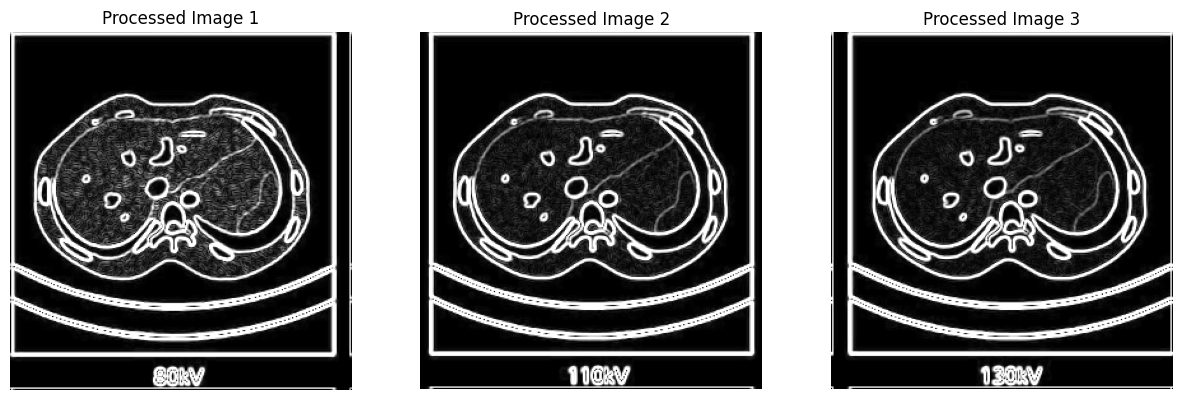

In [14]:

plt.figure(figsize=(15, 5))

for i, part in enumerate(new_parts):
    plt.subplot(1, len(new_parts), i + 1)
    plt.imshow(part, cmap='gray')
    plt.title(f'Processed Image {i+1}')
    plt.axis('off')

plt.show()


In [15]:
for i, part in enumerate(new_parts):
    part_float = part.astype(np.float32)

    start_moms, center_moms = moments_calc(part_float)
    entropy1 = entropy_calc(part_float)
    entropy2 = calculate_entropy_with_histogram(part_float)
    redundancy = calculate_redundancy(part_float)
    print(f'Для части {i+1}: ')
    print(f'Начальные моменты: {start_moms}')
    print(f'Центральные моменты: {center_moms}')
    print(f'Энтропия (как средняя собственная ифнормация): {entropy1:.4f}')
    print(f'Энтропия (через гистограмму): {entropy2:.4f}')
    print(f'Избыточность: {redundancy:.4f}')


Для части 1: 
Начальные моменты: [56.305, 10662.636, 2429799.0, 585430208.0]
Центральные моменты: [0.0, 7492.437, 635075.5, 210861120.0]
Энтропия (как средняя собственная ифнормация): 5.0370
Энтропия (через гистограмму): 5.0370
Избыточность: 0.3703
Для части 2: 
Начальные моменты: [51.283, 10103.545, 2366815.25, 577487680.0]
Центральные моменты: [0.0, 7473.65, 817669.938, 230661376.0]
Энтропия (как средняя собственная ифнормация): 4.8170
Энтропия (через гистограмму): 4.8170
Избыточность: 0.3979
Для части 3: 
Начальные моменты: [49.284, 9844.599, 2320325.0, 567837952.0]
Центральные моменты: [0.0, 7415.677, 869636.562, 236189104.0]
Энтропия (как средняя собственная ифнормация): 4.6860
Энтропия (через гистограмму): 4.6860
Избыточность: 0.4142


УСЕЧЁННОЕ БЛОЧНОЕ КОДИРОВАНИЕ

In [44]:
def count_pixels_above_threshold(block, threshold):
    # Создаем логическую маску: True для пикселей, которые больше c
    mask = block > threshold
    return np.sum(mask)

In [45]:
# Функция для блочного кодирования с усечением
def truncated_block_coding(image, m=8, n=8):
    h, w = image.shape
    compressed_image = np.zeros_like(image)  # Массив для сжатого изображения

    # Проходим по всем блокам
    for i in range(0, h, m):
        for j in range(0, w, n):
            # Получаем блок, проверяя его размеры (если блок выходит за границы изображения)
            block = image[i:i + m, j:j + n]
            p = block.size  # Число пикселей в блоке (включая неполные блоки)

            # Вычисляем среднее и дисперсию
            c = np.sum(block) / p  # Среднее значение
            e = np.sum(block ** 2) / p  # Среднее квадратичное значение

            # Стандартное отклонение
            std = np.sqrt(e - c ** 2)

            # Подсчитываем количество пикселей, которые больше среднего
            q = count_pixels_above_threshold(block, c)

            # Вычисляем уровни квантования
            if p - q == 0:  # Предотвращаем деление на ноль
                a = c
                b = c
            else:
                a = c - std * np.sqrt(q / (p - q))
                b = c + std * np.sqrt(q / (p - q))

            # Применяем квантование к каждому пикселю в блоке
            for x in range(block.shape[0]):  # Используем shape для корректной индексации
                for y in range(block.shape[1]):
                    pix = block[x, y]
                    if pix < c:
                        compressed_image[i + x, j + y] = a
                    else:
                        compressed_image[i + x, j + y] = b

    return compressed_image

In [40]:
def moments_calc(img, powers=[1, 2, 3, 4]):
    strt_moments = []
    cntr_moments = [0 for _ in range(len(powers))]
    height, width = img.shape
    multiplicity = height * width

    for power in powers:
        moment = np.sum(np.power(img, power)) / multiplicity
        strt_moments.append(moment)

    mean_value = strt_moments[0]  # Среднее значение изображения
    cntr_moments[1] = strt_moments[1] - mean_value ** 2  # Второй центральный момент (дисперсия)
 
    strt_moments = [round(float(x), 3) for x in strt_moments]
    cntr_moments = [round(float(x), 3) for x in cntr_moments]

    return strt_moments, cntr_moments


In [48]:
# Функция для отображения изображений
def show_images(original, compressed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Оригинал')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(compressed, cmap='gray')
    plt.title('Сжато (Усечённое кодирование)')
    plt.axis('off')
    
    plt.show()

Часть 1:
Стартовые моменты: [50.711, 9139.719]
Центральные моменты: [0.0, 6568.065]
Среднеквадратичное отклонение: 81.044



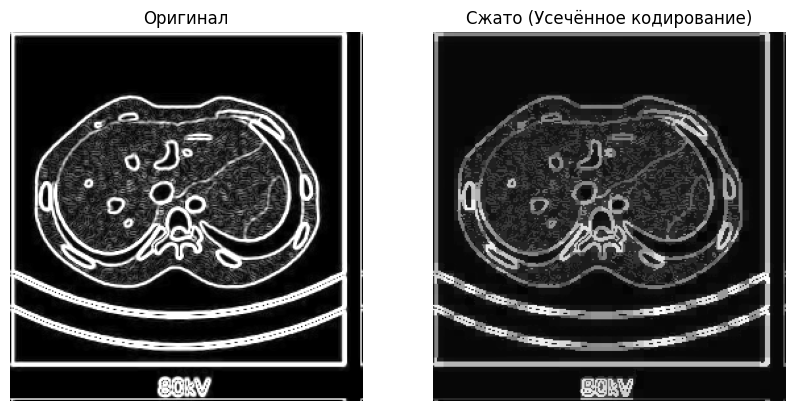

Часть 2:
Стартовые моменты: [45.419, 8545.383]
Центральные моменты: [0.0, 6482.473]
Среднеквадратичное отклонение: 80.514



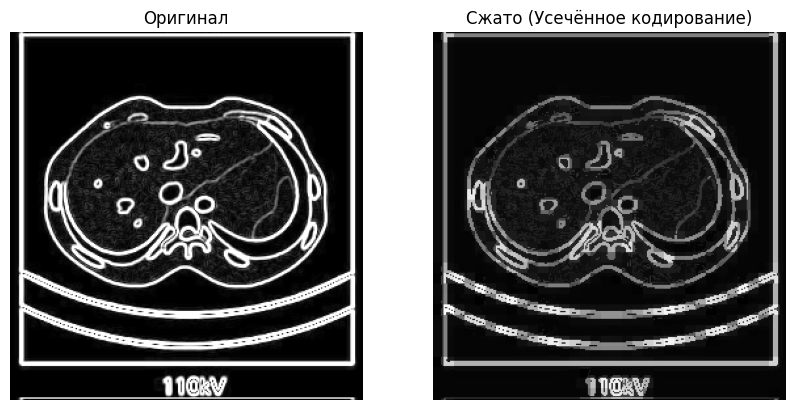

Часть 3:
Стартовые моменты: [42.376, 7921.225]
Центральные моменты: [0.0, 6125.459]
Среднеквадратичное отклонение: 78.265



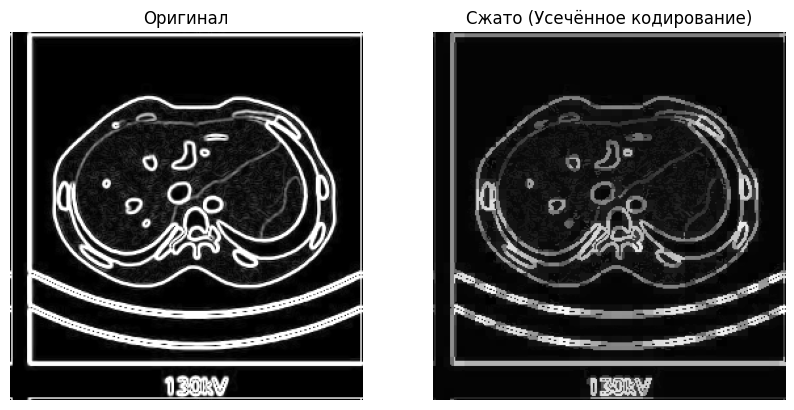

In [50]:
comp_parts = []
for i, part in enumerate(new_parts):
    part_float = part.astype(np.float32)

    # Применяем усечённое блочное кодирование
    compressed_part = truncated_block_coding(part_float, m=8, n=8)
    comp_parts.append(compressed_part)

    # Рассчитываем моменты для сжатого изображения
    strt_moments, cntr_moments = moments_calc(compressed_part, powers=[1, 2])

    # Рассчитываем стандартное отклонение
    if cntr_moments[1] > 0:
        std_deviation = round(np.sqrt(cntr_moments[1]), 3)
    else:
        std_deviation = 0.0  

    # Печатаем результаты
    print(f"Часть {i + 1}:")
    print(f"Стартовые моменты: {strt_moments}")
    print(f"Центральные моменты: {cntr_moments}")
    print(f"Среднеквадратичное отклонение: {std_deviation}")
    print()

    # Отображаем изображения
    show_images(part_float, compressed_part)

АФИННЫЕ ПРЕОБРАЗОВАНИЯ

In [51]:
# Функция для выполнения геометрических преобразований
def affine_transform(image, transformation_type, *params):
    h, w = image.shape
    # Матрица преобразования
    if transformation_type == 'shift':
        tx, ty = params
        M = np.float32([[1, 0, tx], [0, 1, ty]])  # Перенос
    elif transformation_type == 'rotate_scale':
        angle, scale, tx, ty = params
        M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, scale)  # Поворот + Гомотетия
    elif transformation_type == 'scale_rotate':
        scale, angle, tx, ty = params
        M = np.float32([[scale * np.cos(angle), scale * np.sin(angle), tx],
                        [-scale * np.sin(angle), scale * np.cos(angle), ty]])  # Гомотетия + Поворот
    else:
        raise ValueError(f"Unknown transformation type: {transformation_type}")

    # Применяем аффинное преобразование
    transformed_image = cv2.warpAffine(image, M, (w, h))
    return transformed_image

In [52]:
# Функция для отображения изображений
def show_images(original, transformed, title="Transformed Image"):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(transformed, cmap='gray')
    plt.title(title)
    plt.axis('off')
    
    plt.show()

Часть 1:


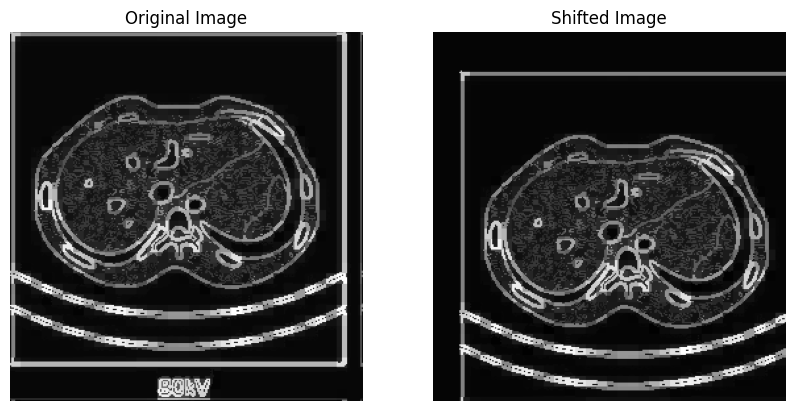

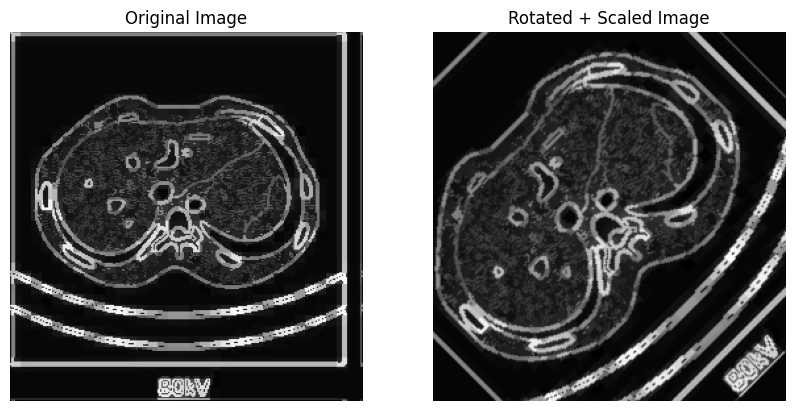

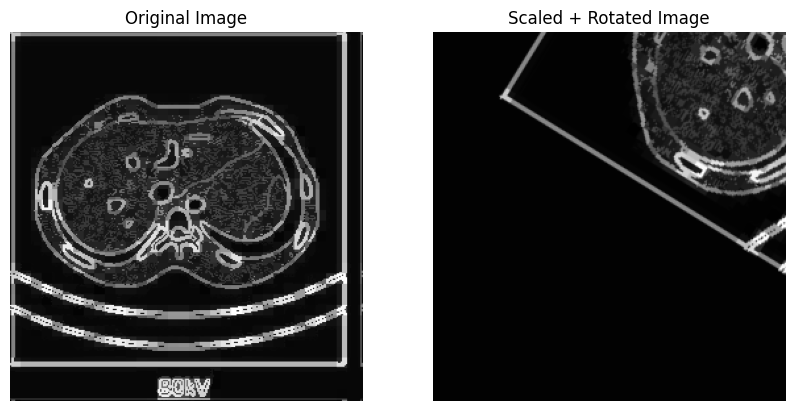

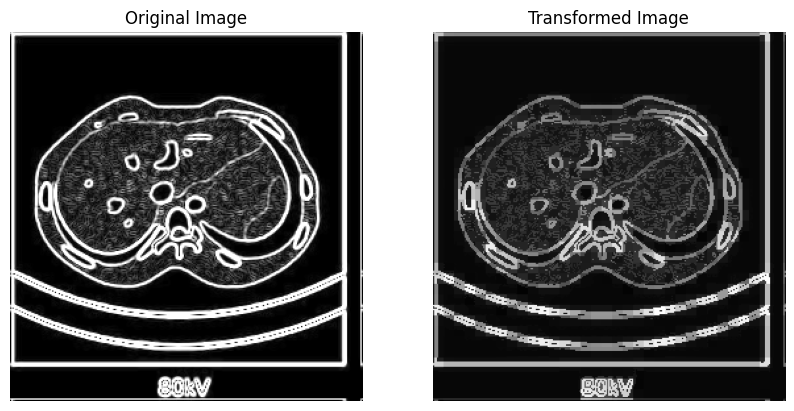

Часть 2:


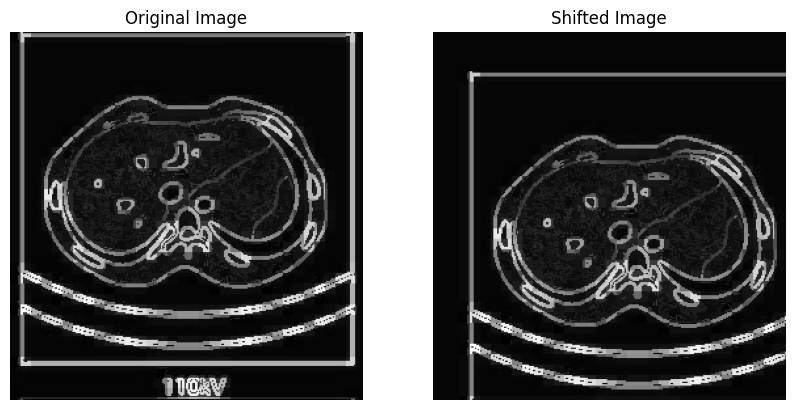

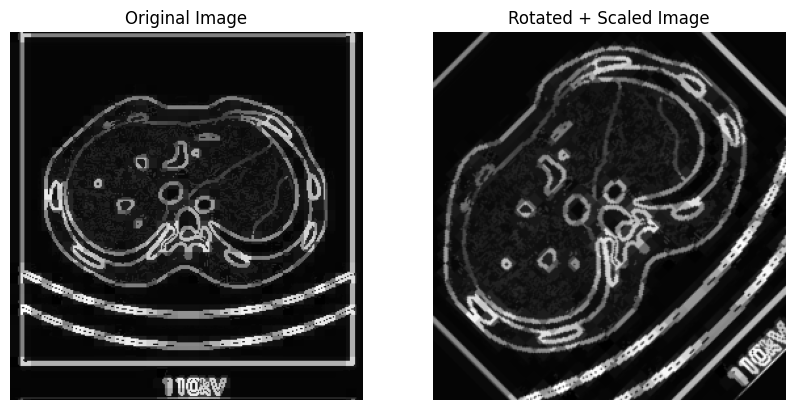

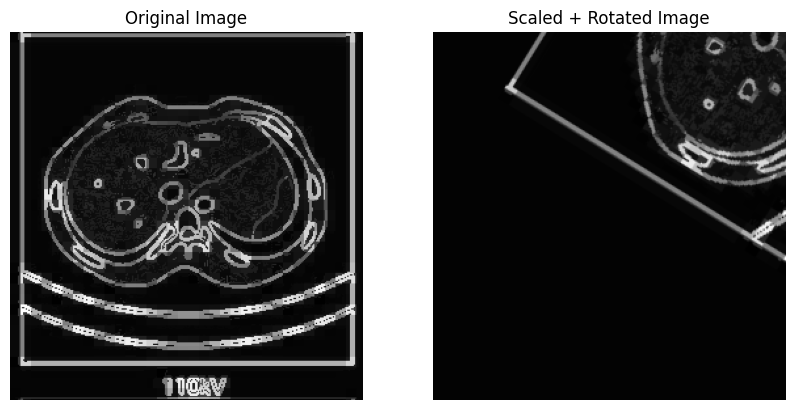

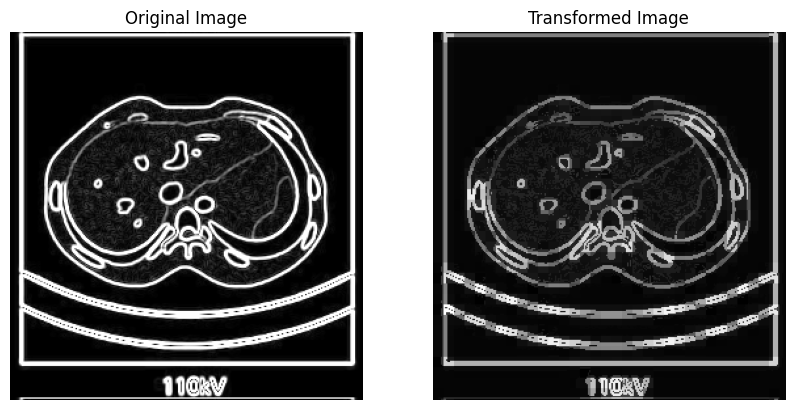

Часть 3:


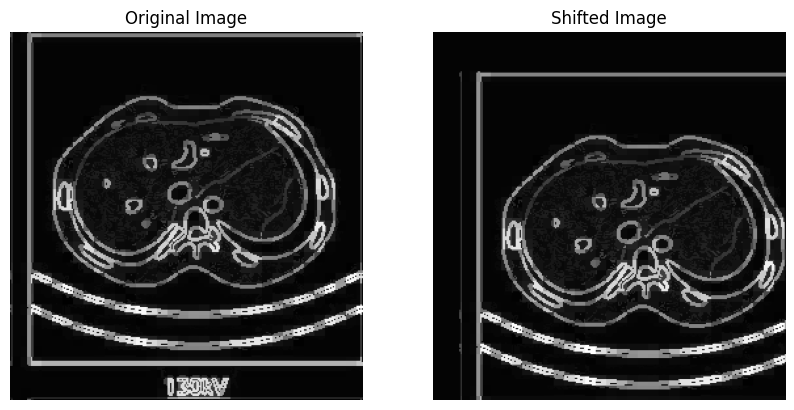

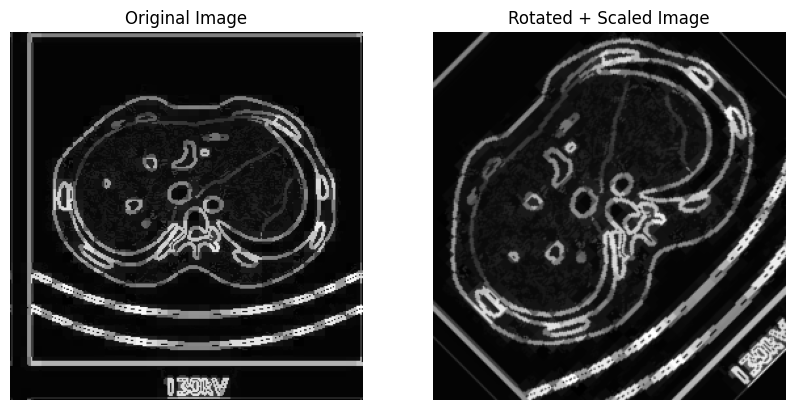

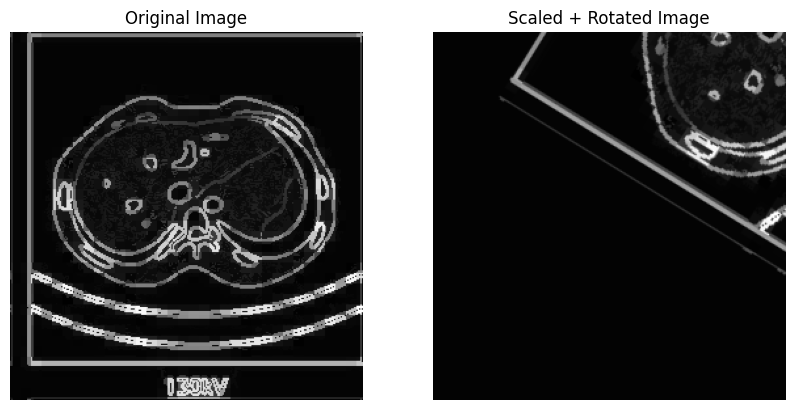

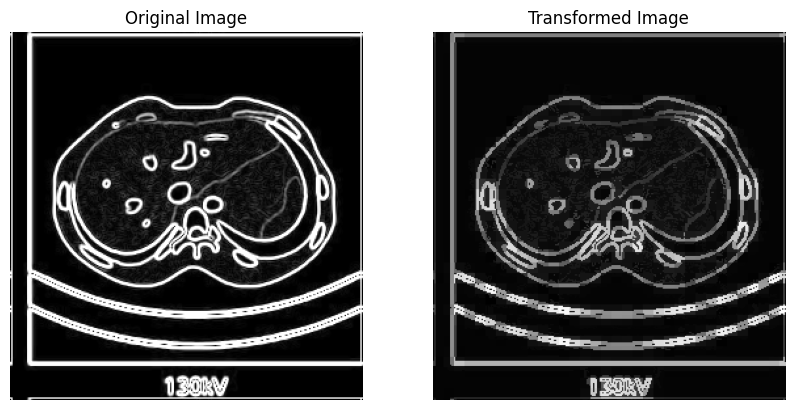

In [55]:
# Пример с изображениями частей (перенос, поворот + гомотетия, гомотетия + поворот)
comp_parts = []
for i, part in enumerate(new_parts):
    print(f"Часть {i + 1}:")
    part_float = part.astype(np.float32)

    # Применяем усечённое блочное кодирование
    compressed_part = truncated_block_coding(part_float, m=8, n=8)
    comp_parts.append(compressed_part)

    # Геометрические преобразования
    # Перенос
    shifted_part = affine_transform(compressed_part, 'shift', 20, 30)
    show_images(compressed_part, shifted_part, title="Shifted Image")

    # Поворот + гомотетия
    rotated_scaled_part = affine_transform(compressed_part, 'rotate_scale', 45, 1.2, 50, 50)
    show_images(compressed_part, rotated_scaled_part, title="Rotated + Scaled Image")

    # Гомотетия + поворот
    scaled_rotated_part = affine_transform(compressed_part, 'scale_rotate', 1.2, 45, 50, 50)
    show_images(compressed_part, scaled_rotated_part, title="Scaled + Rotated Image")

    # Рассчитываем моменты для сжатого изображения
    strt_moments, cntr_moments = moments_calc(compressed_part, powers=[1, 2])

    # Рассчитываем стандартное отклонение
    if cntr_moments[1] > 0:
        std_deviation = round(np.sqrt(cntr_moments[1]), 3)
    else:
        std_deviation = 0.0  

    # Отображаем изображения
    show_images(part_float, compressed_part)